## Análise dos Resultados

### Imports

In [1]:
!pip install matplotlib-venn
!pip install plotly

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3

### Lendo a Base

In [3]:
num_algoritmo = 1

df_alg = pd.read_parquet(f'data/results/df_alg{num_algoritmo}.parquet')
df_bpai = pd.read_parquet(f'data/results/df_bpai_alg{num_algoritmo}.parquet')
df_aih = pd.read_parquet(f'data/results/df_aih_alg{num_algoritmo}.parquet')
df_apac = pd.read_parquet(f'data/results/df_apac_alg{num_algoritmo}.parquet')

## Funções Genéricas

In [4]:
def get_name_datasets():
    """
    Retorna uma lista com o nome dos datasets.
    Utilizada para iterar sobre os conjuntos
    """
    return ['bpai', 'aih', 'apac']

def get_datasets():
    """
    Retorna uma lista com os dataframes de cada algoritmo.
    Utilizada em iterações.
    """
    return[df_bpai, df_aih, df_apac]

def get_len_dataset(dataset_name):
    """Retorna o total de pacientes únicos em cada dataset"""
    if dataset_name == 'bpai':
        return df_bpai['id_paciente'].nunique()
    if dataset_name == 'aih':
        return df_aih['id_paciente'].nunique()
    if dataset_name == 'apac':
        return df_apac['id_paciente'].nunique()

## Comparando os Conjutos

In [5]:
print(' - Pacientes presentes no bpai:', df_bpai['id_paciente'].nunique() / df_alg['id_paciente'].nunique())
print(' - Pacientes presentes no aih:', df_aih['id_paciente'].nunique() / df_alg['id_paciente'].nunique())
print(' - Pacientes presentes no apac:', df_apac['id_paciente'].nunique() / df_alg['id_paciente'].nunique())

 - Pacientes presentes no bpai: 0.6481991914737228
 - Pacientes presentes no aih: 0.9609518559353178
 - Pacientes presentes no apac: 0.6841234840132304


### AIH x BPAI x APAC

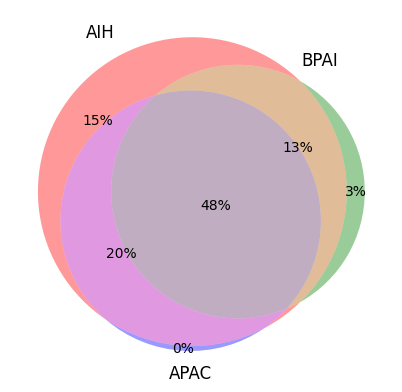

In [6]:
set_bpai = set(df_bpai['id_paciente'])
set_aih = set(df_aih['id_paciente'])
set_apac = set(df_apac['id_paciente'])
total = df_alg.shape[0]
venn3([set_aih, set_bpai, set_apac], ('AIH', 'BPAI', 'APAC'),
       subset_label_formatter=lambda x: f"{(x/total):1.0%}")

plt.show()

## Agora olhando os CIDS

In [7]:
df_aih[df_aih['filtro_cid_principal'] | df_aih['filtro_cid_secundario']]['id_paciente'].nunique()/df_aih['id_paciente'].nunique()

0.9720814609427287

In [8]:

def aplica_filtro_cid(df):
    """Verifica quais registros possuem os principais cids de Lúpus (M32, N08, L93)"""
    df = df.copy()

    for cid in ['M32', 'N08', 'L93']:
        df[f'CID_{cid}_principal'] = df['co_cid_principal'].apply(lambda row: True if cid in row.upper() else False)   

        if 'co_cid_secundario' in df.columns:
            df[f'CID_{cid}_secundario'] = df['co_cid_secundario'].apply(lambda row: True if cid in row.upper() else False)
        else:
            df[f'CID_{cid}_secundario'] = False
        
        # Junta o resultado do cid principal e secundário em uma coluna só
        df[f'CID_{cid}'] = df[f'CID_{cid}_principal'] | df[f'CID_{cid}_secundario']

    return df

In [9]:
dict_sets_cid = {}
list_df = [df_bpai, df_aih, df_apac]
for name_df, df in zip(get_name_datasets(), list_df):
    # Este df contém uma flag para cada CID (M32, N08, L93) em cada registro
    df_cid = aplica_filtro_cid(df)
    for cid in ['M32', 'N08', 'L93']:
        # Verificando todos os id_paciente que possuem cada uma das flags em cada
        # um dos conjuntos (bpai, aih, apac) e em cada algoritmo (alg1, alg2)
        dict_sets_cid[f'set_{name_df}_{cid}'] = set(df_cid[df_cid[f'CID_{cid}']]['id_paciente'])

### Diagrama de Venn

#### BPAI

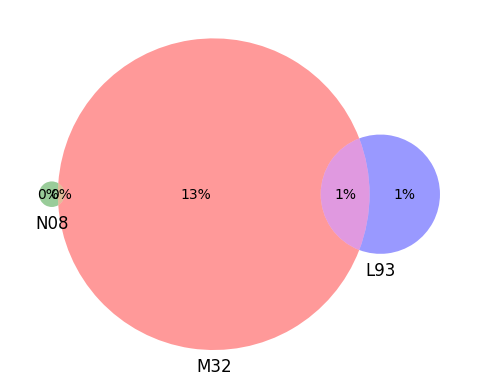

In [10]:
set_bpai_M32 = set(dict_sets_cid['set_bpai_M32'])
set_bpai_N08 = set(dict_sets_cid['set_bpai_N08'])
set_bpai_L93 = set(dict_sets_cid['set_bpai_L93'])

venn3([set_bpai_M32, set_bpai_N08, set_bpai_L93], ('M32', 'N08', 'L93'),
      subset_label_formatter=lambda x: f"{(x/df_alg.shape[0]):1.0%}")

plt.show()

#### CIDS - AIH

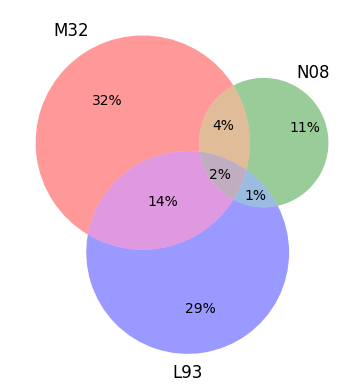

In [11]:
set_aih_M32 = set(dict_sets_cid['set_aih_M32'])
set_aih_N08 = set(dict_sets_cid['set_aih_N08'])
set_aih_L93 = set(dict_sets_cid['set_aih_L93'])

# Porcentagem em relação ao total de pacientes aprovados no algoritmo 1
venn3([set_aih_M32, set_aih_N08, set_aih_L93], ('M32', 'N08', 'L93'),
      subset_label_formatter=lambda x: f"{(x/df_alg['id_paciente'].nunique()):1.0%}")

plt.show()

## Análise dos CIDS

In [12]:
dict_df = {}

# Cria uma lista com os conjuntos de pacientes (bpai, aih e apac)
for dataset_name in get_name_datasets():
    total_len = get_len_dataset(dataset_name)

    # Porcentagem em relação ao total de pacientes de cada conjunto (bpai, aih, apac) aprovados no respectivo algoritmo (1 e 2)
    set_M32 = dict_sets_cid[f'set_{dataset_name}_M32']
    set_N08 = dict_sets_cid[f'set_{dataset_name}_N08']
    set_L93 = dict_sets_cid[f'set_{dataset_name}_L93']
    union_set = set_M32.union(set_N08).union(set_L93)
    dict_aux = {'M32':round(len(set_M32)*100/total_len, 2),
                'N08':round(len(set_N08)*100/total_len, 2),
                'L93':round(len(set_L93)*100/total_len, 2),
                'outros_cids': round((total_len-len(union_set))*100/total_len, 2),
                'total':total_len}
    dict_df[dataset_name] = pd.DataFrame.from_dict(dict_aux, orient='index', columns=['perc_pacientes'])
#px.bar()

In [13]:
def create_df(dataset_name):
    """ Cria um dataframe com a porcentagem de pacientes para que 
    essa informação seja plotada depois"""
    df = pd.DataFrame.from_dict(dict_df[dataset_name]).reset_index()
    df.drop(4, inplace=True, axis=0)
    df.rename(columns={'index':'cid'}, inplace=True)
    df['dataset'] = dataset_name.upper()
    return df[['dataset', 'cid', 'perc_pacientes']].sort_values('perc_pacientes', ascending=True)

df_list = []
for dataset in ['apac', 'bpai', 'aih']:
    df_list.append(create_df(dataset))

df_final = pd.concat(df_list)

#### CIDS por Dataset

In [14]:
px.bar(df_final, y='dataset', x='perc_pacientes', color='cid', orientation='h', barmode='group',
       title=f'Distribuição dos CIDS por Dataset - Algoritmo {num_algoritmo}', text='cid',#text_auto=True,
       category_orders={"cid": ["M32", "L93", "N08", "outros_cids"][::-1]},
       labels={'dataset':'Dataset',
               'perc_pacientes':'Porcentagem de Pacientes',
               'cid':'CID'})

### CIDS do AIH

In [15]:
df = df_aih['no_cid_principal'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['CID Principal'] = df['no_cid_principal'].apply(lambda row: row[:40])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='CID Principal',orientation='h',
       title=f'AIH - CID Principal - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})

### CIDS do BPAI

In [16]:
df = df_bpai['no_cid_principal'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['CID Principal'] = df['no_cid_principal'].apply(lambda row: row[:40])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='CID Principal',orientation='h',
       title=f'BPAI - CID Principal - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})

### CIDS da APAC

In [17]:
df = df_apac['no_cid_principal'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['CID Principal'] = df['no_cid_principal'].apply(lambda row: row[:60])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='CID Principal',orientation='h',
       title=f'APAC - CID Principal - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})

## Procedimentos de cada CID
Apenas dos pacientes aprovados pelo algoritmo.

Nome dos campos de procedimento:
- BPAI: 'no_procedimento_realizado'
- AIH: 'procedimento_principal'e 'desc_procedimento_secundario'
- APAC: 'no_procedimento_principal' e 'no_procedimento_secundario'

In [18]:
df = df_aih['desc_procedimento_secundario'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['Procedimento Secundário'] = df['desc_procedimento_secundario'].apply(lambda row: row[:40])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='Procedimento Secundário',orientation='h',
       title=f'AIH - Procedimento Secundário - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})

### AIH

In [19]:
df = df_aih['procedimento_principal'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['Procedimento Principal'] = df['procedimento_principal'].apply(lambda row: row[:40])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='Procedimento Principal',orientation='h',
       title=f'AIH - Procedimento Principal - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})

### BPAI

In [20]:
df = df_bpai['no_procedimento_realizado'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['Procedimento Realizado'] = df['no_procedimento_realizado'].apply(lambda row: row[:40])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='Procedimento Realizado',orientation='h',
       title=f'BPAI - Procedimento Realizado - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})

### APAC

In [21]:
df = df_apac['no_procedimento_principal'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['Procedimento Principal'] = df['no_procedimento_principal'].apply(lambda row: row[:45])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='Procedimento Principal',orientation='h',
       title=f'APAC - Procedimento Principal - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})

In [22]:
df = df_apac['no_procedimento_secundario'].value_counts(normalize=True).iloc[:15].reset_index()
df.head()
df['Procedimento Secundario'] = df['no_procedimento_secundario'].apply(lambda row: row[:45])
px.bar(df.sort_values(ascending=True, by='proportion'), x='proportion',
       y='Procedimento Secundario',orientation='h',
       title=f'APAC - Procedimento Secundario - Algoritmo {num_algoritmo}',
       color='proportion', labels={'proportion':'Porcentagem'})